In [1]:
!pip install -U duckdb
!pip install -U pandas
!pip install -U polars
!pip install -U 'chdb>=2.0.0b1'
!pip show chdb

  Using cached duckdb-1.0.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.5 MB)
  Using cached duckdb-0.10.3-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.5 MB)
  Using cached pandas-2.2.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
  Using cached pandas-2.2.1-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
  Using cached polars-1.5.0-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (31.6 MB)
  Using cached polars-1.4.1-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (31.5 MB)
  Using cached chdb-2.0.0b1-cp39-cp39-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (134.8 MB)
Name: chdb
Version: 2.0.0b1
Summary: chDB is an in-process SQL OLAP Engine powered by ClickHouse
Home-page: https://github.com/chdb-io/chdb
Author: auxten
Author-email: auxten@clickhouse.com
License: Apache-2.0
Location: /usr/local/lib/python3.9/dist-packages
Requires: 
Required-by: 


In [2]:
# prepare data
import os
import chdb

if not os.path.exists("/tmp/hits.parquet"):
    !wget "https://datasets.clickhouse.com/hits_compatible/athena/hits.parquet" -O /tmp/hits.parquet

# # 1/100 of the data, for testing
if not os.path.exists("/tmp/hits_0.parquet"):
    !wget "https://datasets.clickhouse.com/hits_compatible/athena_partitioned/hits_0.parquet" -O /tmp/hits_0.parquet

# # 10m rows of ClickBench data
if not os.path.exists("/tmp/hits10m.parquet"):
    chdb.query("SELECT * FROM `/tmp/hits.parquet` LIMIT 10000000 INTO OUTFILE '/tmp/hits10m.parquet'").show()


In [1]:
#!python3

import os
import time
import datetime
import chdb
import chdb.dataframe as cdf
import chdb.session as chs
import pandas as pd
import duckdb
# import numpy as np
# import pyarrow as pa
# import pyarrow.parquet as pq



!ls -lh /tmp/hits10m.parquet
!ls -lh /tmp/hits_0.parquet

hits_data = "/tmp/hits10m.parquet"
# hits_data = "/tmp/hits_0.parquet"

t = time.time()
# read parquet file into memory
with open(hits_data, "rb") as f:
    data = f.read()
print("Read parquet file into memory. Time cost:", time.time() - t, "s")
print("Parquet file size:", len(data), "bytes")
del data

# read parquet file as old pandas dataframe
t = time.time()
hits = pd.read_parquet(hits_data)
print("Read parquet file as old pandas dataframe. Time cost:", time.time() - t, "s")
print("Dataframe(numpy) size:", hits.memory_usage().sum(), "bytes")

-rw-r--r-- 1 root root 880M Aug 19 11:34 /tmp/hits10m.parquet
-rw-r--r-- 1 root root 117M Jul  3  2022 /tmp/hits_0.parquet
Read parquet file into memory. Time cost: 0.465517520904541 s
Parquet file size: 922699018 bytes
Read parquet file as old pandas dataframe. Time cost: 10.397734880447388 s
Dataframe(numpy) size: 4700000128 bytes


In [2]:
# fix some types
# print(hits["EventTime"][0:10])
hits["EventTime"] = pd.to_datetime(hits["EventTime"], unit="s")
# print(hits["EventTime"][0:10])

hits["EventDate"] = pd.to_datetime(hits["EventDate"], unit="D")
# print(hits["EventDate"][0:10])

# fix all object columns to string
for col in hits.columns:
    if hits[col].dtype == "O":
        # hits[col] = hits[col].astype('string')
        hits[col] = hits[col].astype(str)

title = hits["Title"]

hits.dtypes

WatchID                 int64
JavaEnable              int16
Title                  object
GoodEvent               int16
EventTime      datetime64[ns]
                    ...      
FromTag                object
HasGCLID                int16
RefererHash             int64
URLHash                 int64
CLID                    int32
Length: 105, dtype: object

In [3]:
# convert dataframe to numpy array
import polars as pl

t = time.time()
pl_df = pl.DataFrame(hits)
print("Convert dataframe to polars dataframe. Time cost:", time.time() - t, "s")

Convert dataframe to polars dataframe. Time cost: 22.901316165924072 s


In [4]:
class myReader(chdb.PyReader):
    def __init__(self, data):
        self.data = data
        self.cursor = 0
        super().__init__(data)

    def read(self, col_names, count):
        # print("read", col_names, count)
        # get the columns from the data with col_names
        block = [self.data[col] for col in col_names]
        # print("columns and rows", len(block), len(block[0]))
        # get the data from the cursor to cursor + count
        block = [col[self.cursor : self.cursor + count] for col in block]
        # print("columns and rows", len(block), len(block[0]))
        # move the cursor
        self.cursor += block[0].shape[0]
        return block

In [5]:
queries = [
    ("Q0", "SELECT COUNT(*) FROM hits;", lambda x: x.count(), lambda x: x.height),
    (
        "Q1",
        "SELECT COUNT(*) FROM hits WHERE AdvEngineID <> 0;",
        lambda x: x[x["AdvEngineID"] != 0].count(),
        lambda x: x.filter(pl.col("AdvEngineID") != 0).height,
    ),
    (
        "Q2",
        "SELECT SUM(AdvEngineID), COUNT(*), AVG(ResolutionWidth) FROM hits;",
        lambda x: (x["AdvEngineID"].sum(), x.shape[0], x["ResolutionWidth"].mean()),
        lambda x: (x["AdvEngineID"].sum(), x.height, x["ResolutionWidth"].mean()),
    ),
    (
        "Q3",
        "SELECT AVG(UserID) FROM hits;",
        lambda x: x["UserID"].mean(),
        lambda x: x["UserID"].mean(),
    ),
    (
        "Q4",
        "SELECT COUNT(DISTINCT UserID) FROM hits;",
        lambda x: x["UserID"].nunique(),
        lambda x: x["UserID"].n_unique(),
    ),
    (
        "Q5",
        "SELECT COUNT(DISTINCT SearchPhrase) FROM hits;",
        lambda x: x["SearchPhrase"].nunique(),
        lambda x: x["SearchPhrase"].n_unique(),
    ),
    (
        "Q6",
        "SELECT MIN(EventDate), MAX(EventDate) FROM hits;",
        lambda x: (x["EventDate"].min(), x["EventDate"].max()),
        lambda x: (x["EventDate"].min(), x["EventDate"].max()),
    ),
    (
        "Q7",
        "SELECT AdvEngineID, COUNT(*) FROM hits WHERE AdvEngineID <> 0 GROUP BY AdvEngineID ORDER BY COUNT(*) DESC;",
        lambda x: x[x["AdvEngineID"] != 0]
        .groupby("AdvEngineID")
        .size()
        .sort_values(ascending=False),
        lambda x: x.filter(pl.col("AdvEngineID") != 0)
        .group_by("AdvEngineID")
        .agg(pl.len().alias("count"))
        .sort("count", descending=True),
    ),
    (
        "Q8",
        "SELECT RegionID, COUNT(DISTINCT UserID) AS u FROM hits GROUP BY RegionID ORDER BY u DESC LIMIT 10;",
        lambda x: x.groupby("RegionID")["UserID"].nunique().nlargest(10),
        lambda x: x.group_by("RegionID")
        .agg(pl.col("UserID").n_unique())
        .sort("UserID", descending=True)
        .head(10),
    ),
    (
        "Q9",
        "SELECT RegionID, SUM(AdvEngineID), COUNT(*) AS c, AVG(ResolutionWidth), COUNT(DISTINCT UserID) FROM hits GROUP BY RegionID ORDER BY c DESC LIMIT 10;",
        lambda x: x.groupby("RegionID")
        .agg({"AdvEngineID": "sum", "ResolutionWidth": "mean", "UserID": "nunique"})
        .nlargest(10, "AdvEngineID"),
        lambda x: x.group_by("RegionID")
        .agg(
            [
                pl.sum("AdvEngineID").alias("AdvEngineID_sum"),
                pl.mean("ResolutionWidth").alias("ResolutionWidth_mean"),
                pl.col("UserID").n_unique().alias("UserID_nunique"),
            ]
        )
        .sort("AdvEngineID_sum", descending=True)
        .head(10),
    ),
    (
        "Q10",
        "SELECT MobilePhoneModel, COUNT(DISTINCT UserID) AS u FROM hits WHERE MobilePhoneModel <> '' GROUP BY MobilePhoneModel ORDER BY u DESC LIMIT 10;",
        lambda x: x[x["MobilePhoneModel"] != ""]
        .groupby("MobilePhoneModel")["UserID"]
        .nunique()
        .nlargest(10),
        lambda x: x.filter(pl.col("MobilePhoneModel") != "")
        .group_by("MobilePhoneModel")
        .agg(pl.col("UserID").n_unique())
        .sort("UserID", descending=True)
        .head(10),
    ),
    (
        "Q11",
        "SELECT MobilePhone, MobilePhoneModel, COUNT(DISTINCT UserID) AS u FROM hits WHERE MobilePhoneModel <> '' GROUP BY MobilePhone, MobilePhoneModel ORDER BY u DESC LIMIT 10;",
        lambda x: x[x["MobilePhoneModel"] != ""]
        .groupby(["MobilePhone", "MobilePhoneModel"])["UserID"]
        .nunique()
        .nlargest(10),
        lambda x: x.filter(pl.col("MobilePhoneModel") != "")
        .group_by(["MobilePhone", "MobilePhoneModel"])
        .agg(pl.col("UserID").n_unique())
        .sort("UserID", descending=True)
        .head(10),
    ),
    (
        "Q12",
        "SELECT SearchPhrase, COUNT(*) AS c FROM hits WHERE SearchPhrase <> '' GROUP BY SearchPhrase ORDER BY c DESC LIMIT 10;",
        lambda x: x[x["SearchPhrase"] != ""]
        .groupby("SearchPhrase")
        .size()
        .nlargest(10),
        lambda x: x.filter(pl.col("SearchPhrase") != "")
        .group_by("SearchPhrase")
        .agg(pl.len().alias("count"))
        .sort("count", descending=True)
        .head(10),
    ),
    (
        "Q13",
        "SELECT SearchPhrase, COUNT(DISTINCT UserID) AS u FROM hits WHERE SearchPhrase <> '' GROUP BY SearchPhrase ORDER BY u DESC LIMIT 10;",
        lambda x: x[x["SearchPhrase"] != ""]
        .groupby("SearchPhrase")["UserID"]
        .nunique()
        .nlargest(10),
        lambda x: x.filter(pl.col("SearchPhrase") != "")
        .group_by("SearchPhrase")
        .agg(pl.col("UserID").n_unique())
        .sort("UserID", descending=True)
        .head(10),
    ),
    (
        "Q14",
        "SELECT SearchEngineID, SearchPhrase, COUNT(*) AS c FROM hits WHERE SearchPhrase <> '' GROUP BY SearchEngineID, SearchPhrase ORDER BY c DESC LIMIT 10;",
        lambda x: x[x["SearchPhrase"] != ""]
        .groupby(["SearchEngineID", "SearchPhrase"])
        .size()
        .nlargest(10),
        lambda x: x.filter(pl.col("SearchPhrase") != "")
        .group_by(["SearchEngineID", "SearchPhrase"])
        .agg(pl.len().alias("count"))
        .sort("count", descending=True)
        .head(10),
    ),
    (
        "Q15",
        "SELECT UserID, COUNT(*) FROM hits GROUP BY UserID ORDER BY COUNT(*) DESC LIMIT 10;",
        lambda x: x.groupby("UserID").size().nlargest(10),
        lambda x: x.group_by("UserID")
        .agg(pl.len().alias("count"))
        .sort("count", descending=True)
        .head(10),
    ),
    (
        "Q16",
        "SELECT UserID, SearchPhrase, COUNT(*) FROM hits GROUP BY UserID, SearchPhrase ORDER BY COUNT(*) DESC LIMIT 10;",
        lambda x: x.groupby(["UserID", "SearchPhrase"]).size().nlargest(10),
        lambda x: x.group_by(["UserID", "SearchPhrase"])
        .agg(pl.len().alias("count"))
        .sort("count", descending=True)
        .head(10),
    ),
    (
        "Q17",
        "SELECT UserID, SearchPhrase, COUNT(*) FROM hits GROUP BY UserID, SearchPhrase LIMIT 10;",
        lambda x: x.groupby(["UserID", "SearchPhrase"]).size().head(10),
        lambda x: x.group_by(["UserID", "SearchPhrase"]).agg(pl.len()).head(10),
    ),
    (
        "Q18",
        "SELECT UserID, extract(minute FROM EventTime) AS m, SearchPhrase, COUNT(*) FROM hits GROUP BY UserID, m, SearchPhrase ORDER BY COUNT(*) DESC LIMIT 10;",
        lambda x: x.groupby([x["UserID"], x["EventTime"].dt.minute, "SearchPhrase"])
        .size()
        .nlargest(10),
        lambda x: x.group_by(
            [pl.col("UserID"), x["EventTime"].dt.minute(), "SearchPhrase"]
        )
        .agg(pl.len().alias("count"))
        .sort("count", descending=True)
        .head(10),
    ),
    (
        "Q19",
        "SELECT UserID FROM hits WHERE UserID = 435090932899640449;",
        lambda x: x[x["UserID"] == 435090932899640449],
        lambda x: x.filter(pl.col("UserID") == 435090932899640449),
    ),
    (
        "Q20",
        "SELECT COUNT(*) FROM hits WHERE URL LIKE '%google%';",
        lambda x: x[x["URL"].str.contains("google")].shape[0],
        lambda x: x.filter(pl.col("URL").str.contains("google")).height,
    ),
    (
        "Q21",
        "SELECT SearchPhrase, MIN(URL), COUNT(*) AS c FROM hits WHERE URL LIKE '%google%' AND SearchPhrase <> '' GROUP BY SearchPhrase ORDER BY c DESC LIMIT 10;",
        lambda x: x[(x["URL"].str.contains("google")) & (x["SearchPhrase"] != "")]
        .groupby("SearchPhrase")
        .agg({"URL": "min", "SearchPhrase": "size"})
        .nlargest(10, "SearchPhrase"),
        lambda x: x.filter(
            (pl.col("URL").str.contains("google")) & (pl.col("SearchPhrase") != "")
        )
        .group_by("SearchPhrase")
        .agg([pl.col("URL").min(), pl.len()])
        .sort("count", descending=True)
        .head(10),
    ),
    (
        "Q22",
        "SELECT SearchPhrase, MIN(URL), MIN(Title), COUNT(*) AS c, COUNT(DISTINCT UserID) FROM hits WHERE Title LIKE '%Google%' AND URL NOT LIKE '%.google.%' AND SearchPhrase <> '' GROUP BY SearchPhrase ORDER BY c DESC LIMIT 10;",
        lambda x: x[
            (x["Title"].str.contains("Google"))
            & (~x["URL"].str.contains(".google."))
            & (x["SearchPhrase"] != "")
        ]
        .groupby("SearchPhrase")
        .agg(
            {"URL": "min", "Title": "min", "SearchPhrase": "size", "UserID": "nunique"}
        )
        .nlargest(10, "SearchPhrase"),
        lambda x: x.filter(
            (pl.col("Title").str.contains("Google"))
            & (~pl.col("URL").str.contains(".google."))
            & (pl.col("SearchPhrase") != "")
        )
        .group_by("SearchPhrase")
        .agg(
            [
                pl.col("URL").min(),
                pl.col("Title").min(),
                pl.len(),
                pl.col("UserID").n_unique(),
            ]
        )
        .sort("count", descending=True)
        .head(10),
    ),
    (
        "Q23",
        "SELECT * FROM hits WHERE URL LIKE '%google%' ORDER BY EventTime LIMIT 10;",
        lambda x: x[x["URL"].str.contains("google")]
        .sort_values(by="EventTime")
        .head(10),
        lambda x: x.filter(pl.col("URL").str.contains("google"))
        .sort("EventTime")
        .head(10),
    ),
    (
        "Q24",
        "SELECT SearchPhrase FROM hits WHERE SearchPhrase <> '' ORDER BY EventTime LIMIT 10;",
        lambda x: x[x["SearchPhrase"] != ""]
        .sort_values(by="EventTime")[["SearchPhrase"]]
        .head(10),
        lambda x: x.filter(pl.col("SearchPhrase") != "")
        .sort("EventTime")
        .select("SearchPhrase")
        .head(10),
    ),
    (
        "Q25",
        "SELECT SearchPhrase FROM hits WHERE SearchPhrase <> '' ORDER BY SearchPhrase LIMIT 10;",
        lambda x: x[x["SearchPhrase"] != ""]
        .sort_values(by="SearchPhrase")[["SearchPhrase"]]
        .head(10),
        lambda x: x.filter(pl.col("SearchPhrase") != "")
        .sort("SearchPhrase")
        .select("SearchPhrase")
        .head(10),
    ),
    (
        "Q26",
        "SELECT SearchPhrase FROM hits WHERE SearchPhrase <> '' ORDER BY EventTime, SearchPhrase LIMIT 10;",
        lambda x: x[x["SearchPhrase"] != ""]
        .sort_values(by=["EventTime", "SearchPhrase"])[["SearchPhrase"]]
        .head(10),
        lambda x: x.filter(pl.col("SearchPhrase") != "")
        .sort(["EventTime", "SearchPhrase"])
        .select("SearchPhrase")
        .head(10),
    ),
    (
        "Q27",
        "SELECT CounterID, AVG(STRLEN(URL)) AS l, COUNT(*) AS c FROM hits WHERE URL <> '' GROUP BY CounterID HAVING COUNT(*) > 100000 ORDER BY l DESC LIMIT 25;",
        lambda x: x[x["URL"] != ""]
        .groupby("CounterID")
        .filter(lambda g: g["URL"].count() > 100000)
        .agg({"URL": lambda url: url.str.len().mean(), "CounterID": "size"})
        .sort_values()
        .head(25),
        lambda x: x.filter(pl.col("URL") != "")  # WHERE URL <> ''
        .group_by("CounterID")  # GROUP BY CounterID
        .agg(
            [
                pl.col("URL")
                .map_elements(lambda y: len(y), return_dtype=pl.Int64)
                .alias("l"),  # AVG(STRLEN(URL))
                pl.len().alias("c"),  # COUNT(*)
            ]
        )
        .filter(pl.col("c") > 100000)  # HAVING COUNT(*) > 100000
        .sort("l", descending=True)  # ORDER BY l DESC
        .limit(25),  # LIMIT 25,
    ),
    (
        "Q28",
        "SELECT REGEXP_REPLACE(Referer, '^https?://(?:www\\.)?([^/]+)/.*$', '\\1') AS k, AVG(STRLEN(Referer)) AS l, COUNT(*) AS c, MIN(Referer) FROM hits WHERE Referer <> '' GROUP BY k HAVING COUNT(*) > 100000 ORDER BY l DESC LIMIT 25;",
        lambda x: (
            x[x["Referer"] != ""]
            .assign(k=x["Referer"].str.extract(r"^https?://(?:www\.)?([^/]+)/.*$")[0])
            .groupby("k")
            .filter(lambda g: g["Referer"].count() > 100000)
            .agg(
                min_referer=("Referer", "min"),
                average_length=("Referer", lambda r: r.str.len().mean()),
            )
            .head(25)
        ),
        lambda x: (
            x.filter(pl.col("Referer") != "")
            .with_columns(
                pl.col("Referer")
                .str.extract(r"^https?://(?:www\\.)?([^/]+)/.*$")
                .alias("k")
            )
            .group_by("k")
            .agg(
                [
                    pl.col("Referer")
                    .map_elements(lambda y: len(y), return_dtype=pl.Int64)
                    # .mean() # skip mean for now
                    .alias("l"),  # AVG(STRLEN(Referer))
                    pl.col("Referer").min().alias("min_referer"),  # MIN(Referer)
                    pl.len().alias("c"),  # COUNT(*)
                ]
            )
            .filter(pl.col("c") > 100000)  # HAVING COUNT(*) > 100000
            .sort("l", descending=True)  # ORDER BY l DESC
            .limit(25)  # LIMIT 25
        ),
    ),
    (
        "Q29",
        "SELECT SUM(ResolutionWidth), SUM(ResolutionWidth + 1), SUM(ResolutionWidth + 2), SUM(ResolutionWidth + 3), SUM(ResolutionWidth + 4), SUM(ResolutionWidth + 5), SUM(ResolutionWidth + 6), SUM(ResolutionWidth + 7), SUM(ResolutionWidth + 8), SUM(ResolutionWidth + 9), SUM(ResolutionWidth + 10), SUM(ResolutionWidth + 11), SUM(ResolutionWidth + 12), SUM(ResolutionWidth + 13), SUM(ResolutionWidth + 14), SUM(ResolutionWidth + 15), SUM(ResolutionWidth + 16), SUM(ResolutionWidth + 17), SUM(ResolutionWidth + 18), SUM(ResolutionWidth + 19), SUM(ResolutionWidth + 20), SUM(ResolutionWidth + 21), SUM(ResolutionWidth + 22), SUM(ResolutionWidth + 23), SUM(ResolutionWidth + 24), SUM(ResolutionWidth + 25), SUM(ResolutionWidth + 26), SUM(ResolutionWidth + 27), SUM(ResolutionWidth + 28), SUM(ResolutionWidth + 29), SUM(ResolutionWidth + 30), SUM(ResolutionWidth + 31), SUM(ResolutionWidth + 32), SUM(ResolutionWidth + 33), SUM(ResolutionWidth + 34), SUM(ResolutionWidth + 35), SUM(ResolutionWidth + 36), SUM(ResolutionWidth + 37), SUM(ResolutionWidth + 38), SUM(ResolutionWidth + 39), SUM(ResolutionWidth + 40), SUM(ResolutionWidth + 41), SUM(ResolutionWidth + 42), SUM(ResolutionWidth + 43), SUM(ResolutionWidth + 44), SUM(ResolutionWidth + 45), SUM(ResolutionWidth + 46), SUM(ResolutionWidth + 47), SUM(ResolutionWidth + 48), SUM(ResolutionWidth + 49), SUM(ResolutionWidth + 50), SUM(ResolutionWidth + 51), SUM(ResolutionWidth + 52), SUM(ResolutionWidth + 53), SUM(ResolutionWidth + 54), SUM(ResolutionWidth + 55), SUM(ResolutionWidth + 56), SUM(ResolutionWidth + 57), SUM(ResolutionWidth + 58), SUM(ResolutionWidth + 59), SUM(ResolutionWidth + 60), SUM(ResolutionWidth + 61), SUM(ResolutionWidth + 62), SUM(ResolutionWidth + 63), SUM(ResolutionWidth + 64), SUM(ResolutionWidth + 65), SUM(ResolutionWidth + 66), SUM(ResolutionWidth + 67), SUM(ResolutionWidth + 68), SUM(ResolutionWidth + 69), SUM(ResolutionWidth + 70), SUM(ResolutionWidth + 71), SUM(ResolutionWidth + 72), SUM(ResolutionWidth + 73), SUM(ResolutionWidth + 74), SUM(ResolutionWidth + 75), SUM(ResolutionWidth + 76), SUM(ResolutionWidth + 77), SUM(ResolutionWidth + 78), SUM(ResolutionWidth + 79), SUM(ResolutionWidth + 80), SUM(ResolutionWidth + 81), SUM(ResolutionWidth + 82), SUM(ResolutionWidth + 83), SUM(ResolutionWidth + 84), SUM(ResolutionWidth + 85), SUM(ResolutionWidth + 86), SUM(ResolutionWidth + 87), SUM(ResolutionWidth + 88), SUM(ResolutionWidth + 89) FROM hits;",
        lambda x: x["ResolutionWidth"].sum()
        + x["ResolutionWidth"].shift(1).sum()
        + x["ResolutionWidth"].shift(2).sum()
        + x["ResolutionWidth"].shift(3).sum()
        + x["ResolutionWidth"].shift(4).sum()
        + x["ResolutionWidth"].shift(5).sum()
        + x["ResolutionWidth"].shift(6).sum()
        + x["ResolutionWidth"].shift(7).sum()
        + x["ResolutionWidth"].shift(8).sum()
        + x["ResolutionWidth"].shift(9).sum()
        + x["ResolutionWidth"].shift(10).sum()
        + x["ResolutionWidth"].shift(11).sum()
        + x["ResolutionWidth"].shift(12).sum()
        + x["ResolutionWidth"].shift(13).sum()
        + x["ResolutionWidth"].shift(14).sum()
        + x["ResolutionWidth"].shift(15).sum()
        + x["ResolutionWidth"].shift(16).sum()
        + x["ResolutionWidth"].shift(17).sum()
        + x["ResolutionWidth"].shift(18).sum()
        + x["ResolutionWidth"].shift(19).sum()
        + x["ResolutionWidth"].shift(20).sum()
        + x["ResolutionWidth"].shift(21).sum()
        + x["ResolutionWidth"].shift(22).sum()
        + x["ResolutionWidth"].shift(23).sum()
        + x["ResolutionWidth"].shift(24).sum()
        + x["ResolutionWidth"].shift(25).sum()
        + x["ResolutionWidth"].shift(26).sum()
        + x["ResolutionWidth"].shift(27).sum()
        + x["ResolutionWidth"].shift(28).sum()
        + x["ResolutionWidth"].shift(29).sum()
        + x["ResolutionWidth"].shift(30).sum()
        + x["ResolutionWidth"].shift(31).sum()
        + x["ResolutionWidth"].shift(32).sum()
        + x["ResolutionWidth"].shift(33).sum()
        + x["ResolutionWidth"].shift(34).sum()
        + x["ResolutionWidth"].shift(35).sum()
        + x["ResolutionWidth"].shift(36).sum()
        + x["ResolutionWidth"].shift(37).sum()
        + x["ResolutionWidth"].shift(38).sum()
        + x["ResolutionWidth"].shift(39).sum()
        + x["ResolutionWidth"].shift(40).sum()
        + x["ResolutionWidth"].shift(41).sum()
        + x["ResolutionWidth"].shift(42).sum()
        + x["ResolutionWidth"].shift(43).sum()
        + x["ResolutionWidth"].shift(44).sum()
        + x["ResolutionWidth"].shift(45).sum()
        + x["ResolutionWidth"].shift(46).sum()
        + x["ResolutionWidth"].shift(47).sum()
        + x["ResolutionWidth"].shift(48).sum()
        + x["ResolutionWidth"].shift(49).sum()
        + x["ResolutionWidth"].shift(50).sum()
        + x["ResolutionWidth"].shift(51).sum()
        + x["ResolutionWidth"].shift(52).sum()
        + x["ResolutionWidth"].shift(53).sum()
        + x["ResolutionWidth"].shift(54).sum()
        + x["ResolutionWidth"].shift(55).sum()
        + x["ResolutionWidth"].shift(56).sum()
        + x["ResolutionWidth"].shift(57).sum()
        + x["ResolutionWidth"].shift(58).sum()
        + x["ResolutionWidth"].shift(59).sum()
        + x["ResolutionWidth"].shift(60).sum()
        + x["ResolutionWidth"].shift(61).sum()
        + x["ResolutionWidth"].shift(62).sum()
        + x["ResolutionWidth"].shift(63).sum()
        + x["ResolutionWidth"].shift(64).sum()
        + x["ResolutionWidth"].shift(65).sum()
        + x["ResolutionWidth"].shift(66).sum()
        + x["ResolutionWidth"].shift(67).sum()
        + x["ResolutionWidth"].shift(68).sum()
        + x["ResolutionWidth"].shift(69).sum()
        + x["ResolutionWidth"].shift(70).sum()
        + x["ResolutionWidth"].shift(71).sum()
        + x["ResolutionWidth"].shift(72).sum()
        + x["ResolutionWidth"].shift(73).sum()
        + x["ResolutionWidth"].shift(74).sum()
        + x["ResolutionWidth"].shift(75).sum()
        + x["ResolutionWidth"].shift(76).sum()
        + x["ResolutionWidth"].shift(77).sum()
        + x["ResolutionWidth"].shift(78).sum()
        + x["ResolutionWidth"].shift(79).sum()
        + x["ResolutionWidth"].shift(80).sum()
        + x["ResolutionWidth"].shift(81).sum()
        + x["ResolutionWidth"].shift(82).sum()
        + x["ResolutionWidth"].shift(83).sum()
        + x["ResolutionWidth"].shift(84).sum()
        + x["ResolutionWidth"].shift(85).sum()
        + x["ResolutionWidth"].shift(86).sum()
        + x["ResolutionWidth"].shift(87).sum()
        + x["ResolutionWidth"].shift(88).sum()
        + x["ResolutionWidth"].shift(89).sum(),
        lambda x: sum(x["ResolutionWidth"][:90] + pl.Series(range(90))),
    ),
    (
        "Q30",
        "SELECT SearchEngineID, ClientIP, COUNT(*) AS c, SUM(IsRefresh), AVG(ResolutionWidth) FROM hits WHERE SearchPhrase <> '' GROUP BY SearchEngineID, ClientIP ORDER BY c DESC LIMIT 10;",
        lambda x: x[x["SearchPhrase"] != ""]
        .groupby(["SearchEngineID", "ClientIP"])
        .agg(
            c=("SearchEngineID", "size"),
            IsRefreshSum=("IsRefresh", "sum"),
            AvgResolutionWidth=("ResolutionWidth", "mean"),
        )
        .nlargest(10, "c"),
        lambda x: x.filter(pl.col("SearchPhrase") != "")
        .group_by(["SearchEngineID", "ClientIP"])
        .agg(
            [
                pl.len().alias("c"),
                pl.sum("IsRefresh").alias("IsRefreshSum"),
                pl.mean("ResolutionWidth").alias("AvgResolutionWidth"),
            ]
        )
        .sort("c", descending=True)
        .head(10),
    ),
    (
        "Q31",
        "SELECT WatchID, ClientIP, COUNT(*) AS c, SUM(IsRefresh), AVG(ResolutionWidth) FROM hits WHERE SearchPhrase <> '' GROUP BY WatchID, ClientIP ORDER BY c DESC LIMIT 10;",
        lambda x: x[x["SearchPhrase"] != ""]
        .groupby(["WatchID", "ClientIP"])
        .agg(
            c=("WatchID", "size"),
            IsRefreshSum=("IsRefresh", "sum"),
            AvgResolutionWidth=("ResolutionWidth", "mean"),
        )
        .nlargest(10, "c"),
        lambda x: x.filter(pl.col("SearchPhrase") != "")
        .group_by(["WatchID", "ClientIP"])
        .agg(
            [
                pl.len().alias("c"),
                pl.sum("IsRefresh").alias("IsRefreshSum"),
                pl.mean("ResolutionWidth").alias("AvgResolutionWidth"),
            ]
        )
        .sort("c", descending=True)
        .head(10),
    ),
    (
        "Q32",
        "SELECT WatchID, ClientIP, COUNT(*) AS c, SUM(IsRefresh), AVG(ResolutionWidth) FROM hits GROUP BY WatchID, ClientIP ORDER BY c DESC LIMIT 10;",
        lambda x: x.groupby(["WatchID", "ClientIP"])
        .agg(
            c=("WatchID", "size"),
            IsRefreshSum=("IsRefresh", "sum"),
            AvgResolutionWidth=("ResolutionWidth", "mean"),
        )
        .nlargest(10, "c"),
        lambda x: x.group_by(["WatchID", "ClientIP"])
        .agg(
            [
                pl.len().alias("c"),
                pl.sum("IsRefresh").alias("IsRefreshSum"),
                pl.mean("ResolutionWidth").alias("AvgResolutionWidth"),
            ]
        )
        .sort("c", descending=True)
        .head(10),
    ),
    (
        "Q33",
        "SELECT URL, COUNT(*) AS c FROM hits GROUP BY URL ORDER BY c DESC LIMIT 10;",
        lambda x: x.groupby("URL").size().nlargest(10).reset_index(name="c"),
        lambda x: x.group_by("URL")
        .agg(pl.len().alias("c"))
        .sort("c", descending=True)
        .head(10),
    ),
    (
        "Q34",
        "SELECT 1, URL, COUNT(*) AS c FROM hits GROUP BY 1, URL ORDER BY c DESC LIMIT 10;",
        lambda x: x.groupby(["URL"]).size().nlargest(10).reset_index(name="c"),
        lambda x: x.group_by("URL")
        .agg(pl.len().alias("c"))
        .sort("c", descending=True)
        .head(10),
    ),
    (
        "Q35",
        "SELECT ClientIP, ClientIP - 1, ClientIP - 2, ClientIP - 3, COUNT(*) AS c FROM hits GROUP BY ClientIP, ClientIP - 1, ClientIP - 2, ClientIP - 3 ORDER BY c DESC LIMIT 10;",
        lambda x: x.assign(
            **{f"ClientIP_minus_{i}": x["ClientIP"] - i for i in range(1, 4)}
        )
        .groupby(
            ["ClientIP", "ClientIP_minus_1", "ClientIP_minus_2", "ClientIP_minus_3"]
        )
        .size()
        .nlargest(10)
        .reset_index(name="c"),
        lambda x: x.with_columns([pl.col("ClientIP")])
        .group_by(
            ["ClientIP"]
        )
        .agg(pl.len().alias("c"))
        .sort("c", descending=True)
        .head(10),
    ),
    (
        "Q36",
        "SELECT URL, COUNT(*) AS PageViews FROM hits WHERE CounterID = 62 AND EventDate >= '2013-07-01' AND EventDate <= '2013-07-31' AND DontCountHits = 0 AND IsRefresh = 0 AND URL <> '' GROUP BY URL ORDER BY PageViews DESC LIMIT 10;",
        lambda x: x[
            (x["CounterID"] == 62)
            & (x["EventDate"] >= "2013-07-01")
            & (x["EventDate"] <= "2013-07-31")
            & (x["DontCountHits"] == 0)
            & (x["IsRefresh"] == 0)
            & (x["URL"] != "")
        ]
        .groupby("URL")
        .size()
        .nlargest(10),
        lambda x: x.filter(
            (pl.col("CounterID") == 62)
            & (pl.col("EventDate") >= pl.datetime(2013, 7, 1))
            & (pl.col("EventDate") <= pl.datetime(2013, 7, 31))
            & (pl.col("DontCountHits") == 0)
            & (pl.col("IsRefresh") == 0)
            & (pl.col("URL") != "")
        )
        .group_by("URL")
        .agg(pl.len().alias("PageViews"))
        .sort("PageViews", descending=True)
        .head(10),
    ),
    (
        "Q37",
        "SELECT Title, COUNT(*) AS PageViews FROM hits WHERE CounterID = 62 AND EventDate >= '2013-07-01' AND EventDate <= '2013-07-31' AND DontCountHits = 0 AND IsRefresh = 0 AND Title <> '' GROUP BY Title ORDER BY PageViews DESC LIMIT 10;",
        lambda x: x[
            (x["CounterID"] == 62)
            & (x["EventDate"] >= "2013-07-01")
            & (x["EventDate"] <= "2013-07-31")
            & (x["DontCountHits"] == 0)
            & (x["IsRefresh"] == 0)
            & (x["Title"] != "")
        ]
        .groupby("Title")
        .size()
        .nlargest(10),
        lambda x: x.filter(
            (pl.col("CounterID") == 62)
            & (pl.col("EventDate") >= pl.datetime(2013, 7, 1))
            & (pl.col("EventDate") <= pl.datetime(2013, 7, 31))
            & (pl.col("DontCountHits") == 0)
            & (pl.col("IsRefresh") == 0)
            & (pl.col("Title") != "")
        )
        .group_by("Title")
        .agg(pl.len().alias("PageViews"))
        .sort("PageViews", descending=True)
        .head(10),
    ),
    (
        "Q38",
        "SELECT URL, COUNT(*) AS PageViews FROM hits WHERE CounterID = 62 AND EventDate >= '2013-07-01' AND EventDate <= '2013-07-31' AND IsRefresh = 0 AND IsLink <> 0 AND IsDownload = 0 GROUP BY URL ORDER BY PageViews DESC LIMIT 10 OFFSET 1000;",
        lambda x: x[
            (x["CounterID"] == 62)
            & (x["EventDate"] >= "2013-07-01")
            & (x["EventDate"] <= "2013-07-31")
            & (x["IsRefresh"] == 0)
            & (x["IsLink"] != 0)
            & (x["IsDownload"] == 0)
        ]
        .groupby("URL")
        .size()
        .nlargest(10)
        .reset_index(name="PageViews")
        .iloc[1000:1010],
        lambda x: x.filter(
            (pl.col("CounterID") == 62)
            & (pl.col("EventDate") >= pl.datetime(2013, 7, 1))
            & (pl.col("EventDate") <= pl.datetime(2013, 7, 31))
            & (pl.col("IsRefresh") == 0)
            & (pl.col("IsLink") != 0)
            & (pl.col("IsDownload") == 0)
        )
        .group_by("URL")
        .agg(pl.len().alias("PageViews"))
        .sort("PageViews", descending=True)
        .slice(1000, 10),
    ),
    (
        "Q39",
        "SELECT TraficSourceID, SearchEngineID, AdvEngineID, CASE WHEN (SearchEngineID = 0 AND AdvEngineID = 0) THEN Referer ELSE '' END AS Src, URL AS Dst, COUNT(*) AS PageViews FROM hits WHERE CounterID = 62 AND EventDate >= '2013-07-01' AND EventDate <= '2013-07-31' AND IsRefresh = 0 GROUP BY TraficSourceID, SearchEngineID, AdvEngineID, Src, Dst ORDER BY PageViews DESC LIMIT 10 OFFSET 1000;",
        lambda x: x[
            (x["CounterID"] == 62)
            & (x["EventDate"] >= "2013-07-01")
            & (x["EventDate"] <= "2013-07-31")
            & (x["IsRefresh"] == 0)
        ]
        .groupby(["TraficSourceID", "SearchEngineID", "AdvEngineID", "Referer", "URL"])
        .size()
        .nlargest(10)
        .reset_index(name="PageViews")
        .iloc[1000:1010],
        lambda x: time.sleep(1)
        # Crash with:
        #   thread '<unnamed>' panicked at crates/polars-time/src/windows/duration.rs:215:21:
        #   expected leading integer in the duration string, found m
        #   note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace
        # lambda x: x.filter(
        #     (pl.col("CounterID") == 62)
        #     & (pl.col("EventDate") >= pl.datetime(2013, 7, 1))
        #     & (pl.col("EventDate") <= pl.datetime(2013, 7, 31))
        #     & (pl.col("IsRefresh") == 0)
        # )
        # .group_by(
        #     [
        #         "TraficSourceID",
        #         "SearchEngineID",
        #         "AdvEngineID",
        #         # pl.when(pl.col("SearchEngineID").eq(0) & pl.col("AdvEngineID").eq(0))
        #         # .then(pl.col("Referer"))
        #         # .otherwise("")
        #         # .alias("Src"),
        #         "URL",
        #     ]
        # )
        # .agg(pl.len().alias("PageViews"))
        # .sort("PageViews", descending=True)
        # .slice(1000, 10),
    ),
    (
        "Q40",
        "SELECT URLHash, EventDate, COUNT(*) AS PageViews FROM hits WHERE CounterID = 62 AND EventDate >= '2013-07-01' AND EventDate <= '2013-07-31' AND IsRefresh = 0 AND TraficSourceID IN (-1, 6) AND RefererHash = 3594120000172545465 GROUP BY URLHash, EventDate ORDER BY PageViews DESC LIMIT 10 OFFSET 100;",
        lambda x: x[
            (x["CounterID"] == 62)
            & (x["EventDate"] >= "2013-07-01")
            & (x["EventDate"] <= "2013-07-31")
            & (x["IsRefresh"] == 0)
            & (x["TraficSourceID"].isin([-1, 6]))
            & (x["RefererHash"] == 3594120000172545465)
        ]
        .groupby(["URLHash", "EventDate"])
        .size()
        .nlargest(10)
        .reset_index(name="PageViews")
        .iloc[100:110],
        lambda x: x.filter(
            (pl.col("CounterID") == 62)
            & (pl.col("EventDate") >= pl.datetime(2013, 7, 1))
            & (pl.col("EventDate") <= pl.datetime(2013, 7, 31))
            & (pl.col("IsRefresh") == 0)
            & (pl.col("TraficSourceID").is_in([-1, 6]))
            & (pl.col("RefererHash") == 3594120000172545465)
        )
        .group_by(["URLHash", "EventDate"])
        .agg(pl.len().alias("PageViews"))
        .sort("PageViews", descending=True)
        .slice(100, 10),
    ),
    (
        "Q41",
        "SELECT WindowClientWidth, WindowClientHeight, COUNT(*) AS PageViews FROM hits WHERE CounterID = 62 AND EventDate >= '2013-07-01' AND EventDate <= '2013-07-31' AND IsRefresh = 0 AND DontCountHits = 0 AND URLHash = 2868770270353813622 GROUP BY WindowClientWidth, WindowClientHeight ORDER BY PageViews DESC LIMIT 10 OFFSET 10000;",
        lambda x: x[
            (x["CounterID"] == 62)
            & (x["EventDate"] >= "2013-07-01")
            & (x["EventDate"] <= "2013-07-31")
            & (x["IsRefresh"] == 0)
            & (x["DontCountHits"] == 0)
            & (x["URLHash"] == 2868770270353813622)
        ]
        .groupby(["WindowClientWidth", "WindowClientHeight"])
        .size()
        .nlargest(10)
        .reset_index(name="PageViews")
        .iloc[10000:10010],
        lambda x: x.filter(
            (pl.col("CounterID") == 62)
            & (pl.col("EventDate") >= pl.datetime(2013, 7, 1))
            & (pl.col("EventDate") <= pl.datetime(2013, 7, 31))
            & (pl.col("IsRefresh") == 0)
            & (pl.col("DontCountHits") == 0)
            & (pl.col("URLHash") == 2868770270353813622)
        )
        .group_by(["WindowClientWidth", "WindowClientHeight"])
        .agg(pl.len().alias("PageViews"))
        .sort("PageViews", descending=True)
        .slice(10000, 10),
    ),
    (
        "Q42",
        "SELECT DATE_TRUNC('minute', EventTime) AS M, COUNT(*) AS PageViews FROM hits WHERE CounterID = 62 AND EventDate >= '2013-07-14' AND EventDate <= '2013-07-15' AND IsRefresh = 0 AND DontCountHits = 0 GROUP BY DATE_TRUNC('minute', EventTime) ORDER BY DATE_TRUNC('minute', EventTime) LIMIT 10 OFFSET 1000;",
        lambda x: x[
            (x["CounterID"] == 62)
            & (x["EventDate"] >= "2013-07-14")
            & (x["EventDate"] <= "2013-07-15")
            & (x["IsRefresh"] == 0)
            & (x["DontCountHits"] == 0)
        ]
        .groupby(pd.Grouper(key="EventTime", freq="T"))
        .size()
        .reset_index(name="PageViews")
        .iloc[1000:1010],
        lambda x: time.sleep(1)
        # Crash with:
        #   thread '<unnamed>' panicked at crates/polars-time/src/windows/duration.rs:215:21:
        #   expected leading integer in the duration string, found m
        # lambda x: x.filter(
        #     (pl.col("CounterID") == 62)
        #     & (pl.col("EventDate") >= pl.datetime(2013, 7, 14))
        #     & (pl.col("EventDate") <= pl.datetime(2013, 7, 15))
        #     & (pl.col("IsRefresh") == 0)
        #     & (pl.col("DontCountHits") == 0)
        # )
        # .group_by(pl.col("EventTime").dt.truncate("minute"))
        # .agg(pl.len().alias("PageViews"))
        # .slice(1000, 10),
    ),
]

In [6]:
counter = 0


def runDuckDB(con, sql):
    used_time = -1
    try:
        t = time.time()
        ret = con.execute(sql).fetch_df()
        used_time = time.time() - t
        print("DuckDB time:", used_time)
        print("DuckDB return:\n", ret)
    except Exception as e:
        print("DuckDB error:", e)
    return used_time

def runChDB(sess, sql):
    used_time = -1
    # replace 'hits' with 'Python(df_reader)'
    sql = sql.replace("hits", "Python(hits)")
    # sql = sql.replace("hits", "__hits__")
    sql = sql.replace("STRLEN", "length")
    if "SELECT DATE_TRUNC('minute', EventTime) AS M" in sql:
        sql = "SELECT DATE_TRUNC('minute', EventTime) AS M, COUNT(*) AS PageViews FROM Python(hits) WHERE CounterID = 62  AND EventDate >= '2013-07-14'  AND EventDate <= '2013-07-15' AND IsRefresh = 0 AND DontCountHits = 0 GROUP BY DATE_TRUNC('minute', EventTime) ORDER BY DATE_TRUNC('minute', EventTime) LIMIT 10 OFFSET 1000"
    try:
        t = time.time()
        ret = chdb.query(sql, "CSV")
        used_time = time.time() - t
        print("chDB time:", used_time)
        print("chDB return:\n", ret)
    except Exception as e:
        print("chDB error:", e)
    return used_time

def runPandas(f):
    t = time.time()
    ret = f(hits)
    used_time = time.time() - t
    print("Pandas time:", used_time)
    print("Pandas return:\n", ret)
    return used_time

def runPolars(f):
    used_time = -1
    try:
        t = time.time()
        ret = f(pl_df)
        used_time = time.time() - t
        print("Polars time:", used_time)
        print("Polars return:\n", ret)
    except Exception as e:
        print("Polars error:", e)
    return used_time

def bench(q):
    global counter
    con = duckdb.connect()
    # df_reader = myReader(hits)
    duckdb_time = []
    chdb_time = []
    pandas_time = []
    polars_time = []
    sql = q[1]
    print(q[0], sql)
    for i in range(1):
        duckdb_time.append(runDuckDB(con, sql))
        chdb_time.append(runChDB(None, sql))
        pandas_time.append(runPandas(q[2]))
        polars_time.append(runPolars(q[3]))
    counter += 1
    return duckdb_time, chdb_time, pandas_time, polars_time

In [7]:
# Run the benchmark!
# Benchmark results
duckdb_times = []
chdb_times = []
pandas_times = []
polars_times = []

counter = 0
for q in queries:
    duckdb_time, chdb_time, pandas_time, polars_time = bench(q)
    # remove the min/max time, take the average time
    if len(duckdb_time) > 2:
        duckdb_time = sorted(duckdb_time)[1:-1]
        chdb_time = sorted(chdb_time)[1:-1]
        pandas_time = sorted(pandas_time)[1:-1]
        polars_time = sorted(polars_time)[1:-1]

    duckdb_times.append(sum(duckdb_time) / len(duckdb_time))
    chdb_times.append(sum(chdb_time) / len(chdb_time))
    pandas_times.append(sum(pandas_time) / len(pandas_time))
    polars_times.append(sum(polars_time) / len(polars_time))

Q0 SELECT COUNT(*) FROM hits;
DuckDB time: 0.034766435623168945
DuckDB return:
    count_star()
0      10000000
chDB time: 0.0491330623626709
chDB return:
 10000000

Pandas time: 8.846198797225952
Pandas return:
 WatchID        10000000
JavaEnable     10000000
Title          10000000
GoodEvent      10000000
EventTime      10000000
                 ...   
FromTag        10000000
HasGCLID       10000000
RefererHash    10000000
URLHash        10000000
CLID           10000000
Length: 105, dtype: int64
Polars time: 1.8835067749023438e-05
Polars return:
 10000000
Q1 SELECT COUNT(*) FROM hits WHERE AdvEngineID <> 0;
DuckDB time: 0.024944543838500977
DuckDB return:
    count_star()
0         99649
chDB time: 0.025159835815429688
chDB return:
 99649

Pandas time: 0.18808650970458984
Pandas return:
 WatchID        99649
JavaEnable     99649
Title          99649
GoodEvent      99649
EventTime      99649
               ...  
FromTag        99649
HasGCLID       99649
RefererHash    99649
URLHash   

DuckDB times: [[0.03473329544067383], [0.025869369506835938], [0.02449941635131836], [0.021502971649169922], [0.07661056518554688], [0.11784601211547852], [0.023169994354248047], [0.041997432708740234], [0.08279561996459961], [0.12752676010131836], [0.049619197845458984], [0.05812263488769531], [0.10427713394165039], [0.16024351119995117], [0.12470531463623047], [0.07800555229187012], [0.14101672172546387], [0.13824796676635742], [0.19573760032653809], [0.04209160804748535], [0.12423968315124512], [0.13030076026916504], [0.23919463157653809], [0.4751307964324951], [0.16602039337158203], [0.23991131782531738], [0.19497394561767578], [0.14258074760437012], [0.37261152267456055], [0.3752312660217285], [0.08300089836120605], [0.10579490661621094], [0.2147054672241211], [0.2616574764251709], [0.21707653999328613], [0.1144096851348877], [0.0702214241027832], [0.15410351753234863], [0.04920172691345215], [0.13008761405944824], [0.04686141014099121], [0.04792666435241699], [0.04334378242492676

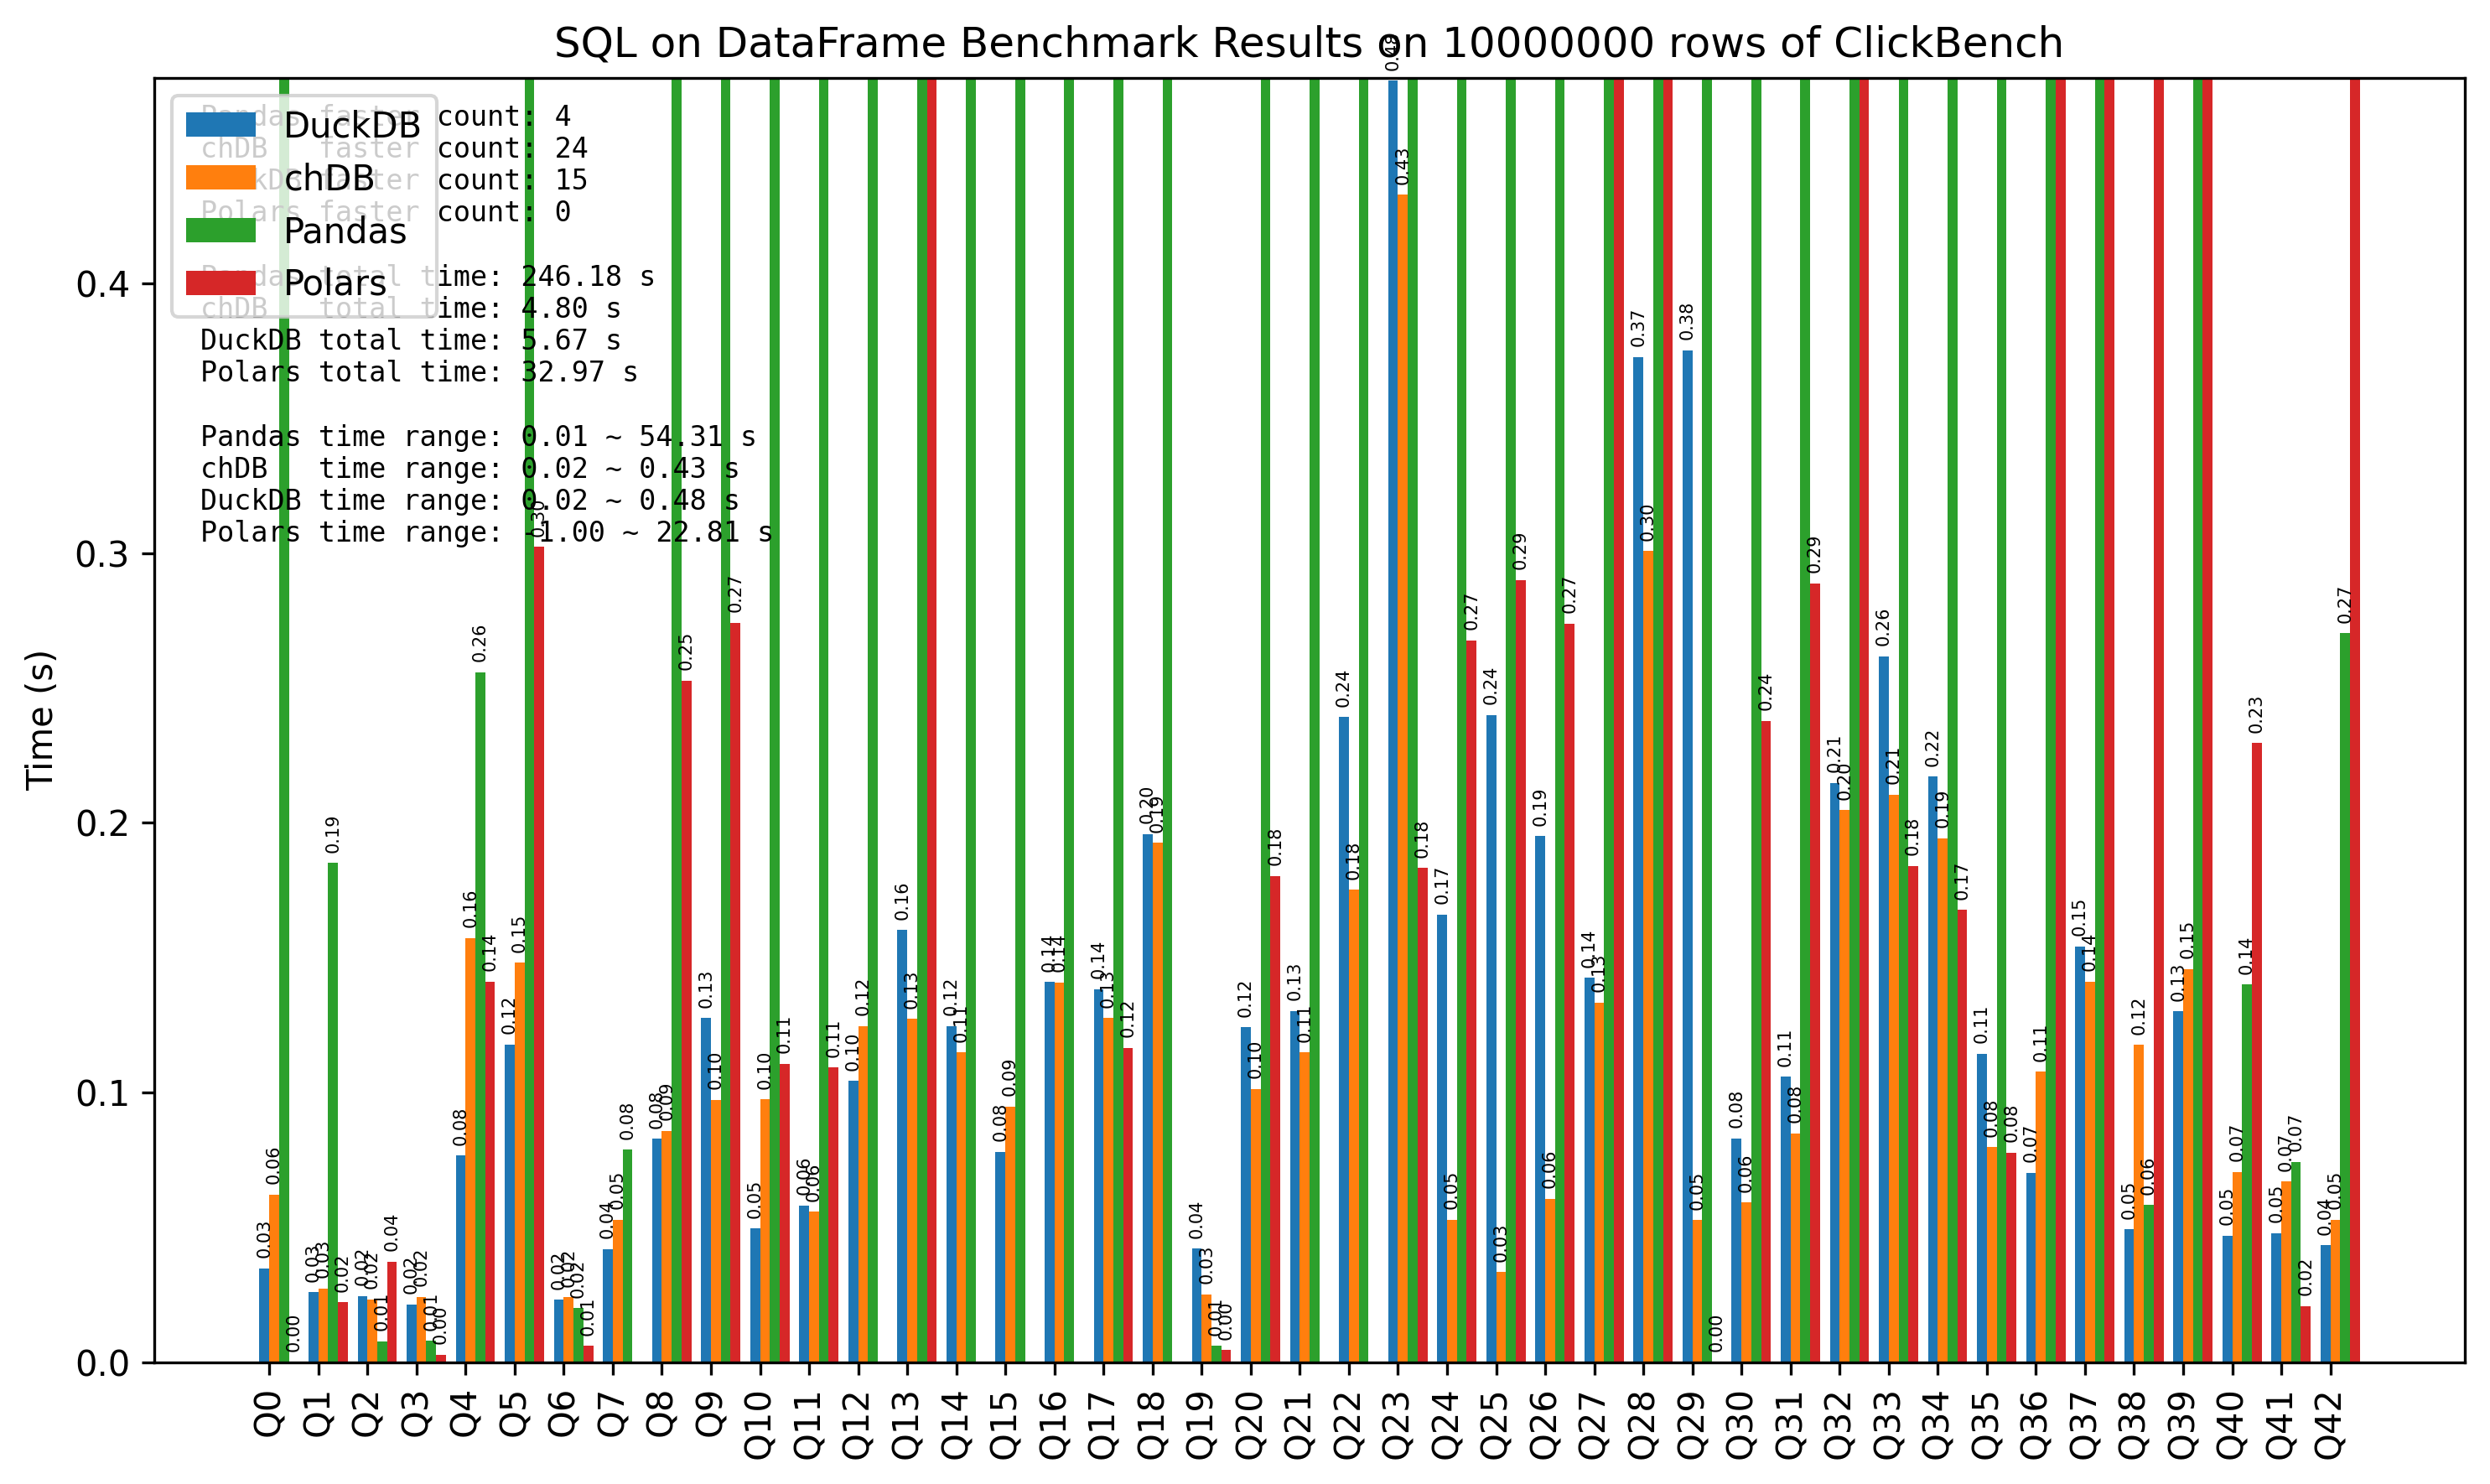

In [ ]:
import matplotlib.pyplot as plt

print("DuckDB times:", [[t] for t in duckdb_times])
print("chDB times:", [[t] for t in chdb_times])
print("Pandas times:", [[t] for t in pandas_times])
print("Polars times:", [[t] for t in polars_times])

x = range(len(queries))
xlable = [f"Q{num}" for num in x]
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

rects1 = ax.bar(x, duckdb_times, width, label="DuckDB")
rects2 = ax.bar([i + width for i in x], chdb_times, width, label="chDB")
rects3 = ax.bar([i + 2 * width for i in x], pandas_times, width, label="Pandas")
rects4 = ax.bar([i + 3 * width for i in x], polars_times, width, label="Polars")

ax.set_ylabel("Time (s)")
# ax.set_ylim(0, max(chdb_times) * 1.1)
ax.set_title(f"SQL on DataFrame Benchmark Results on {hits.shape[0]} rows of ClickBench")
ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(xlable, rotation=90)
ax.legend()

# Add the value of each bar on top
for rect in rects1 + rects2 + rects3 + rects4:
    height = rect.get_height()
    ax.annotate(
        f"{height:.2f}",
        xy=(rect.get_x() + rect.get_width() / 2, height),
        xytext=(0, 3),
        textcoords="offset points",
        ha="center",
        va="bottom",
        rotation=90,  # Rotate the text 90°
        fontsize=5,  # Set the font size to a smaller value
    )

# Compute comparison counts and total times
better = []
for i in range(len(queries)):
    min_val = min(duckdb_times[i], chdb_times[i], pandas_times[i])
    if min_val == duckdb_times[i]:
        better.append("DuckDB")
    elif min_val == chdb_times[i]:
        better.append("chDB")
    elif min_val == pandas_times[i]:
        better.append("Pandas")
    elif min_val == polars_times[i]:
        better.append("Polars")
    else:
        better.append("Unknown")
print("DuckDB faster count:", better.count("DuckDB"))
print("chDB faster count:", better.count("chDB"))
print("Pandas faster count:", better.count("Pandas"))
print("Polars faster count:", better.count("Polars"))
print("DuckDB total time:", sum(duckdb_times))
print("chDB total time:", sum(chdb_times))
print("Pandas total time:", sum(pandas_times))
print("Polars total time:", sum(polars_times))


# Display summary statistics on the plot
summary_text = f"Pandas faster count: {better.count('Pandas')}\n"
summary_text += f"chDB   faster count: {better.count('chDB')}\n"
summary_text += f"DuckDB faster count: {better.count('DuckDB')}\n"
summary_text += f"Polars faster count: {better.count('Polars')}\n\n"
summary_text += f"Pandas total time: {sum(pandas_times):.2f} s\n"
summary_text += f"chDB   total time: {sum(chdb_times):.2f} s\n"
summary_text += f"DuckDB total time: {sum(duckdb_times):.2f} s\n"
summary_text += f"Polars total time: {sum(polars_times):.2f} s\n\n"

summary_text += (
    f"Pandas time range: {min(pandas_times):.2f} ~ {max(pandas_times):.2f} s\n"
)
summary_text += f"chDB   time range: {min(chdb_times):.2f} ~ {max(chdb_times):.2f} s\n"
summary_text += f"DuckDB time range: {min(duckdb_times):.2f} ~ {max(duckdb_times):.2f} s\n"
summary_text += f"Polars time range: {min(polars_times):.2f} ~ {max(polars_times):.2f} s"

# Position the text at the top right of the chart
ax.text(
    0.02,
    0.98,
    summary_text,
    transform=ax.transAxes,
    fontsize=8,
    verticalalignment="top",
    horizontalalignment="left",
    fontfamily="monospace",
)

fig.tight_layout()
plt.show()